# Smoothing Required for a Good Coarsening $P$
We expect to need smoother TVs for $P$ than for $R$.

In [42]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [43]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 5

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.523385380551302


## Level 0->1 Coarsening

In [44]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level0 = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level0.location = np.arange(n)

### Coarsening

In [45]:
def create_coarsening(level, nu, aggregate_size, num_components):
    # Generate relaxed test vectors.
    x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
    _LOGGER.info("Generating relaxed TF with {} sweeps, RER {:.3f}".format(nu, norm(level.a.dot(x)) / norm(x)))
    #x_log.append(x)

    # Create coarsening. Force 2 coarse vars per aggregate so we can test alignment.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    R = r.tile(level.size // aggregate_size)
    return x, R

In [46]:
# Check Relaxation smoothing.
num_sweeps = hm.setup.auto_setup.check_relaxation_speed(0, level0)[1]
aggregate_size, num_components = 4, 2
x, R = create_coarsening(level0, 2 * num_sweeps, aggregate_size, num_components)

INFO     level 0 size 96 relax conv 0.93 shrinkage 0.64 PODR RER 0.55 after 5 sweeps. Work 1.0 eff 0.64
INFO     Generating relaxed TF with 10 sweeps, RER 0.312


### Interpolation Performance vs. #TF Sweeps

In [47]:
def two_level_performance(level, num_sweeps: int, num_tf_sweeps: np.ndarray,
                           aggregate_size, num_components):
    num_cycle_sweeps = np.arange(1, num_sweeps + 3)
    
    for nu in num_tf_sweeps:
        if nu == -1:
            print("Eigenvector TFs")
            x = hm.analysis.ideal.ideal_tv(level.a, num_examples)[0]
        else:
            print("#TF sweeeps", nu)
            x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
        
        r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
        R = r.tile(level.size // aggregate_size)
        # TODO: replace by local mock cycle rate.
        mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in num_cycle_sweeps])

        p_experiment = {}
        l2c_experiment = {}
        coarsening_values = (False, True)
        titles = ("P^T A P", "R A P")
        conv = pd.DataFrame(mock_conv.transpose(), index=num_cycle_sweeps, columns=("Mock", )).transpose()
        for use_r_as_restriction, title in zip(coarsening_values, titles):
            calibers = (2, 4) # if use_r_as_restriction else (2, 4)
            l2c = []
            p_caliber = []
            for caliber in calibers:
                #print("caliber", caliber)

                p = hm.setup.auto_setup.create_interpolation(
                    x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
                    neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
                    caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
                #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

                ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                        level.a, level.location, R, p, aggregate_size, num_components,
                            use_r_as_restriction=use_r_as_restriction)
                ac = ml[1].a
                fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
                symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
                two_level_conv = np.array([
                    hm.repetitive.locality.two_level_conv_factor(
                        ml, nu, print_frequency=None)[1]
                     for nu in num_cycle_sweeps])
                l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
                p_caliber.append(p)

            p_experiment[use_r_as_restriction] = p_caliber
            l2c_experiment[use_r_as_restriction] = l2c

        all_conv = pd.DataFrame(np.array(
            [[np.nan] * 5 + list(mock_conv)] +
            [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                            columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(num_cycle_sweeps), 
                                index=("Mock", ) + tuple("{} caliber {}".format(title, caliber) for title in titles
                                  for caliber in calibers))
        styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
        display_html(styler._repr_html_(), raw=True)

In [48]:
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 7)))
two_level_performance(level0, num_sweeps, num_tf_sweeps, aggregate_size, num_components)

#TF sweeeps 0


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7
Mock,nan,nan,nan,nan,nan,0.91,0.87,0.81,0.80,0.79,0.79,0.77
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,1.00,0.99,0.98,0.97,0.96,0.96,0.93
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,1.00,0.99,0.98,0.97,0.96,0.95,0.94
R A P caliber 2,1.00,2.00,192.00,1.20,0.18,1.00,0.99,0.98,0.97,0.96,0.95,0.94
R A P caliber 4,1.00,4.00,384.00,1.20,0.23,1.00,0.99,0.99,0.98,0.96,0.95,0.94


#TF sweeeps 2


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7
Mock,nan,nan,nan,nan,nan,0.67,0.36,0.19,0.15,0.19,0.20,0.18
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,19.86,34.79,44.07,47.70,48.02,46.60,45.09
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,4.60,5.63,5.40,5.10,4.82,4.87,5.01
R A P caliber 2,1.00,2.00,192.00,1.20,0.10,2.60,3.36,3.82,4.01,4.02,3.91,3.77
R A P caliber 4,1.00,4.00,384.00,1.20,0.09,10.18,11.42,13.28,13.53,13.48,12.92,12.34


#TF sweeeps 4


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7
Mock,nan,nan,nan,nan,nan,0.58,0.29,0.17,0.17,0.16,0.14,0.09
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.50,0.85,0.77,0.65,0.60,0.59,0.63
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.76,0.48,0.28,0.33,0.23,0.25,0.28
R A P caliber 2,1.00,2.00,192.00,1.20,0.11,1.07,1.28,1.00,0.90,0.92,1.00,1.05
R A P caliber 4,1.00,4.00,384.00,1.20,0.03,0.67,0.46,0.37,0.36,0.29,0.28,0.31


#TF sweeeps 8


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7
Mock,nan,nan,nan,nan,nan,0.62,0.31,0.17,0.13,0.15,0.12,0.09
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.51,0.35,0.39,0.41,0.39,0.40,0.35
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.34,0.21,0.15,0.12,0.14,0.11
R A P caliber 2,1.00,2.00,192.00,1.20,0.04,0.54,0.35,0.36,0.45,0.53,0.53,0.49
R A P caliber 4,1.00,4.00,384.00,1.20,0.03,0.71,0.35,0.23,0.19,0.18,0.17,0.14


#TF sweeeps 16


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7
Mock,nan,nan,nan,nan,nan,0.60,0.33,0.19,0.14,0.14,0.13,0.09
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.53,0.37,0.45,0.48,0.43,0.41,0.41
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.33,0.21,0.13,0.15,0.14,0.10
R A P caliber 2,1.00,2.00,192.00,1.20,0.03,6.68,5.32,2.01,0.62,1.02,1.11,0.79
R A P caliber 4,1.00,4.00,384.00,1.20,0.02,0.97,0.80,0.28,0.24,0.21,0.24,0.23


#TF sweeeps 32


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7
Mock,nan,nan,nan,nan,nan,0.62,0.33,0.20,0.14,0.15,0.13,0.09
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.52,0.35,0.44,0.45,0.39,0.40,0.41
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.31,0.19,0.13,0.15,0.14,0.10
R A P caliber 2,1.00,2.00,192.00,1.20,0.07,1.00,0.52,0.47,0.44,0.38,0.37,0.37
R A P caliber 4,1.00,4.00,384.00,1.20,0.01,0.82,0.47,0.29,0.21,0.17,0.13,0.10


#TF sweeeps 64


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7
Mock,nan,nan,nan,nan,nan,0.59,0.33,0.19,0.14,0.14,0.13,0.09
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.50,0.35,0.40,0.43,0.36,0.36,0.36
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.59,0.33,0.21,0.14,0.15,0.14,0.10
R A P caliber 2,1.00,2.00,192.00,1.20,0.03,0.55,0.44,0.40,0.43,0.36,0.36,0.36
R A P caliber 4,1.00,4.00,384.00,1.20,0.00,1.16,0.82,0.37,0.21,0.16,0.14,0.12


Looks like a $P^T A P$ gives good rated with with only $4$ TF sweeps. $8$ are required to get a good $R A P$. So we could possibly benefit from a bootstrap step, although the overhead might not even be justified here.

### Create Level 1

In [ ]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
#p = p_experiment[True][-1]  # R*A*P P high order
p = p_experiment[True][-1]  # R*A*P P high order, near-symmetric here.

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

## Level 1->2
Loading a 6-point stencil obtained by 4/2 coarsening of level 0 from file.

In [49]:
a1 = scipy.sparse.load_npz('level_1_operator.npz')
level1 = hm.setup.hierarchy.create_finest_level(a1)
level0_location = np.arange(2 * a1.shape[0]) #level0.location
level1.location = hm.setup.geometry.coarse_locations(level0_location, aggregate_size, num_components)
pd.DataFrame(a1.todense()[4:6, np.unique(a1[4:6].nonzero()[1])])

,0,1,2,3,4,5
0,0.15,-0.19,-0.03,-0.05,0.15,0.14
1,0.15,-0.16,-0.04,-0.63,-0.19,-0.16


### Coarsening

In [50]:
# Check Relaxation smoothing.
num_sweeps = hm.setup.auto_setup.check_relaxation_speed(0, level1)[1]
aggregate_size, num_components = 4, 2
x, R = create_coarsening(level1, 30 * num_sweeps, aggregate_size, num_components)

INFO     level 0 size 48 relax conv 0.90 shrinkage 0.43 PODR RER 0.23 after 2 sweeps. Work 1.0 eff 0.43
INFO     Generating relaxed TF with 60 sweeps, RER 0.009


,0,1,2,3,4,5,6,7,8,9
0,0.71,-0.13,-0.39,0.57,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.11,0.68,-0.70,-0.19,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.71,-0.13,-0.39,0.57,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.11,0.68,-0.70,-0.19,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71,-0.13


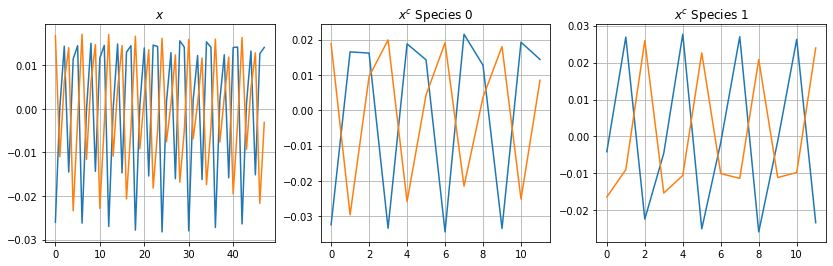

In [51]:
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Interpolation Performance vs. #TF Sweeps

In [52]:
#num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 10)))
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 10), [-1]))
two_level_performance(level1, 10, num_tf_sweeps, aggregate_size, num_components)

#TF sweeeps 0


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.75,0.71,0.68,0.67,0.65,0.65,0.66,0.66,0.66,0.66,0.66,0.66
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.01,1.03,0.93,0.87,0.82,0.83,0.79,0.82,0.93,0.90,0.81,0.95,1.00
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.01,0.99,0.93,0.90,0.88,0.84,0.81,0.78,0.84,0.99,0.94,0.95,0.91
R A P caliber 2,1.00,2.00,96.00,1.00,0.02,0.99,0.92,0.89,0.84,0.84,0.80,0.77,0.91,0.88,0.94,0.96,0.99
R A P caliber 4,1.00,4.00,192.00,1.00,0.13,0.98,0.95,0.89,0.86,0.82,0.79,0.78,0.87,0.77,0.93,0.99,1.00


#TF sweeeps 2


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.41,0.45,0.39,0.33,0.27,0.23,0.19,0.16,0.14,0.12,0.11,0.11
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,1.48,1.08,0.97,0.94,1.00,1.01,1.01,1.01,1.01,1.01,1.01,1.01
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,8.11,1.35,0.62,0.61,0.61,0.60,0.60,0.60,0.60,0.60,0.60,0.60
R A P caliber 2,1.00,2.00,96.00,1.00,0.04,1.36,1.05,0.92,0.91,0.99,1.00,1.01,1.01,1.01,1.01,1.01,1.01
R A P caliber 4,1.00,4.00,192.00,1.00,0.04,0.89,0.89,0.89,0.89,0.89,0.89,0.89,0.89,0.89,0.89,0.89,0.89


#TF sweeeps 4


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.37,0.38,0.35,0.30,0.25,0.21,0.15,0.15,0.12,0.11,0.10,0.10
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,3.56,2.48,2.14,1.81,1.53,1.29,1.07,0.92,0.98,1.01,1.01,1.03
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,1.26,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62
R A P caliber 2,1.00,2.00,96.00,1.00,0.07,1.67,1.44,1.24,0.96,0.89,0.91,0.97,1.01,1.01,1.01,1.01,1.01
R A P caliber 4,1.00,4.00,192.00,1.00,0.06,1.04,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05


#TF sweeeps 8


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.29,0.32,0.25,0.22,0.19,0.16,0.13,0.09,0.08,0.08,0.07,0.06
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,6.79,5.46,3.17,2.15,1.93,1.66,1.47,1.32,1.29,1.18,1.13,1.16
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,3.94,0.89,0.26,0.25,0.26,0.26,0.26,0.26,0.26,0.26,0.26,0.26
R A P caliber 2,1.00,2.00,96.00,1.00,0.09,9.14,6.51,5.68,4.82,4.07,3.45,2.92,2.47,2.09,1.76,1.47,1.26
R A P caliber 4,1.00,4.00,192.00,1.00,0.06,1.43,1.40,1.40,1.40,1.39,1.39,1.39,1.39,1.39,1.39,1.39,1.39


#TF sweeeps 16


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.33,0.20,0.17,0.13,0.12,0.08,0.08,0.06,0.05,0.05,0.05,0.05
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,214.92,134.51,118.16,99.71,83.19,69.98,58.65,49.16,41.17,34.46,28.81,24.07
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,0.86,0.34,0.17,0.16,0.13,0.11,0.10,0.09,0.09,0.09,0.09,0.09
R A P caliber 2,1.00,2.00,96.00,1.00,0.02,207.65,131.79,115.43,97.73,81.71,68.87,57.86,48.60,40.80,34.22,28.68,24.02
R A P caliber 4,1.00,4.00,192.00,1.00,0.03,1.02,0.88,0.89,0.89,0.88,0.88,0.87,0.88,0.87,0.87,0.87,0.87


#TF sweeeps 32


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.31,0.28,0.22,0.18,0.14,0.13,0.10,0.09,0.08,0.07,0.07,0.06
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,8.26,5.41,4.70,3.98,3.32,2.76,2.35,1.98,1.66,1.35,1.16,1.08
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,5.73,1.14,0.32,0.16,0.13,0.12,0.11,0.09,0.08,0.06,0.06,0.05
R A P caliber 2,1.00,2.00,96.00,1.00,0.08,4.43,3.21,2.78,2.41,2.04,1.74,1.50,1.37,1.27,1.19,1.11,1.05
R A P caliber 4,1.00,4.00,192.00,1.00,0.07,0.91,0.79,0.77,0.77,0.76,0.75,0.75,0.74,0.74,0.74,0.74,0.74


#TF sweeeps 64


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.30,0.31,0.25,0.21,0.18,0.15,0.13,0.10,0.07,0.07,0.06,0.05
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,7.30,4.79,4.16,3.51,2.94,2.48,2.08,1.75,1.47,1.24,1.03,1.06
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,0.48,0.22,0.07,0.05,0.04,0.03,0.03,0.01,0.01,0.01,0.01,0.01
R A P caliber 2,1.00,2.00,96.00,1.00,0.05,2.77,2.12,1.84,1.56,1.32,1.12,0.92,0.78,0.77,0.71,0.70,0.70
R A P caliber 4,1.00,4.00,192.00,1.00,0.04,0.60,0.30,0.23,0.21,0.16,0.14,0.12,0.12,0.12,0.11,0.11,0.10


#TF sweeeps 128


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.37,0.43,0.35,0.30,0.25,0.21,0.18,0.13,0.12,0.11,0.10,0.09
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,7.30,4.83,4.19,3.55,2.97,2.50,2.10,1.76,1.46,1.16,1.14,1.07
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,0.58,0.11,0.06,0.09,0.07,0.05,0.03,0.02,0.01,0.02,0.01,0.01
R A P caliber 2,1.00,2.00,96.00,1.00,0.07,2.11,1.58,1.36,1.16,0.94,0.82,0.70,0.66,0.60,0.59,0.53,0.49
R A P caliber 4,1.00,4.00,192.00,1.00,0.04,0.31,0.20,0.18,0.13,0.12,0.10,0.09,0.07,0.06,0.05,0.04,0.03


#TF sweeeps 256


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.36,0.38,0.29,0.29,0.25,0.21,0.17,0.14,0.12,0.10,0.09,0.09
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,7.32,4.81,4.18,3.53,2.95,2.49,2.09,1.75,1.47,1.22,1.05,1.00
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.01,17.99,10.36,9.37,7.78,6.45,5.38,4.47,3.72,3.09,2.56,2.12,1.76
R A P caliber 2,1.00,2.00,96.00,1.00,0.07,2.09,1.54,1.39,1.19,1.00,0.86,0.71,0.70,0.63,0.58,0.53,0.50
R A P caliber 4,1.00,4.00,192.00,1.00,0.40,95.56,63.63,55.63,48.54,41.46,35.75,30.71,26.39,22.65,19.43,16.65,14.26


#TF sweeeps 512


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.29,0.33,0.28,0.24,0.20,0.16,0.14,0.11,0.09,0.08,0.07,0.07
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,7.30,4.81,4.18,3.53,2.95,2.49,2.09,1.75,1.48,1.23,1.12,0.98
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.01,1.91,1.41,1.20,1.01,0.85,0.71,0.60,0.50,0.42,0.36,0.31,0.28
R A P caliber 2,1.00,2.00,96.00,1.00,0.07,2.58,1.92,1.65,1.38,1.16,1.00,0.84,0.80,0.72,0.68,0.65,0.59
R A P caliber 4,1.00,4.00,192.00,1.00,0.66,1.28,0.69,0.72,0.70,0.69,0.71,0.71,0.71,0.68,0.66,0.64,0.62


Eigenvector TFs


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.33,0.39,0.31,0.27,0.23,0.19,0.16,0.12,0.11,0.09,0.08,0.08
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,7.36,4.86,4.22,3.56,2.98,2.51,2.11,1.76,1.49,1.23,1.07,1.00
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,1.02,0.78,0.30,0.10,0.09,0.08,0.07,0.06,0.05,0.04,0.04,0.03
R A P caliber 2,1.00,2.00,96.00,1.00,0.05,2.20,1.68,1.48,1.25,1.05,0.88,0.74,0.66,0.63,0.60,0.56,0.50
R A P caliber 4,1.00,4.00,192.00,1.00,0.02,3.21,1.93,1.11,0.75,0.57,0.46,0.41,0.39,0.37,0.36,0.35,0.34


* Here we require $32$ sweeps to get a good $P^T A P$, and $64$ to get a good $R A P$. So bootstrap is definitely beneficial. 
* Note that there is "relaxing too much": past $100$ sweeps, the 2-level convergence degrades. Some degeneration in the TFs likely.
* Also, $R A P$ becomes less symmetric then. This happens with both weighted/unweighted LS fitting.
* Mock cycle rates stabilize after $4-8$ relaxations.

## Notes
* A lot of samples with small # TF sweeps still gives us a good R because we have a large sample size for SVD.
* Ideal vectors work: $P^T A P$ with high order $P$ is good. $R A P$ is OK. So relaxing to the limit is fine, provided the vectors are orthogonalized.

## TODO

* Try ideal vectors.
* Do relaxations to generate an initial $P$.
* Bootstrap is for identifying slow-to-converge components and improve $P$ for them.
* $8$ TF sweeps only - what is the initial cycle rate? Does it have good shrinkage? Even if asymptotic rate is bad.
* Compare first mock cycle rates vs. 2-level cycle rates.
* Check if divergence is because the last cycles ar bad but before were good.
* Add orthogonalization / Ritz projection - does the result improve with more relax sweeps then?
* Do we need to regularize?
* Try larger domain, at which # relax does the problem start? Is it domain size dependent?